# Getting Started with AuctionGym
## My Experiments Run

In [1]:
import matplotlib.pyplot as plt
import numpy as np
# from collections import defaultdict
from main import parse_config, instantiate_agents, instantiate_auction, simulation_run
# from tqdm.notebook import tqdm
from tqdm.notebook import tqdm
# from Bidder import *

In [2]:
# config_file = '../config-mine/FP_Epsilon-average-out-results-test.json'
# config_file = '../config-mine/FP_EpsilonGreedy.json'
# config_file = '../config-mine/SP_UCB1.json'
# config_file = '../config-mine/SP_Exp3-Truthful.json'
# config_file = '../config-mine/FP_Exp3-Truthful.json'
# config_file = '../config-mine/SP_Exp3.json'
# config_file = '../config-mine/SP_EpsilonGreedy-Exp3-UCB1.json'
# config_file = '../config-mine/SP_GPUCB-Exp3.json'
# config_file = '../config-mine/SP_IGPR-Exp3.json'
# config_file = '../config-mine/SP_warmGPR-Exp3.json'
# config_file = '../config-mine/SP_warmGPR-UCB1.json'
# config_file = '../config-mine/SP_warmGPR-IGPR.json'
# config_file = '../config-mine/SP_SAC-Exp3.json'
# config_file = '../config-mine/SP_SB3-discr-vs-cont.json'
# config_file = '../config-mine/SP_GPUCB-ctxt.json'
# config_file = '../config-mine/SP_expert-Exp3.json'
# config_file = '../config-mine/SP_EpsilonGreedy-Exp3-ExpertKMeans.json'
# config_file = '../config-mine/Novelty/SP_NoveltyNN-Exp3.json'
config_file = '../config-mine/SP_TruthfulBandit_gather_data.json'

graph_title = config_file

In [3]:
# Parse configuration file
rng, config, agent_configs, agents2items, agents2item_values,\
num_runs, max_slots, embedding_size, embedding_var,\
obs_embedding_size = parse_config(config_file)

num_iter = config['num_iter']

print('--- Auction ---')
print(config['allocation'])
print()

print('--- My Agents ---')
my_agents_names = []
i=0
for agent in config['agents']:
    for copies in range(agent['num_copies']):
        i+=1
        # my_agents_names.append(f'{i}.{agent["bidder"]["type"]} ({agent["name"]})')
        my_agents_names.append(f'{i}. {agent["name"]}')
        # print(f'{i}) {agent["bidder"]["type"]}')
print(my_agents_names)

print()
print('--- Runs Number ---')
print(f"making {config['num_runs']} runs\n  for each, {config['num_iter']} iterations\n    for each, {config['rounds_per_iter']} episodes")
print(f"\t -> total: {config['num_runs']*config['num_iter']*config['rounds_per_iter']}")

--- Auction ---
SecondPrice

--- My Agents ---
['1. Truthful Bidder']

--- Runs Number ---
making 1 runs
  for each, 10 iterations
    for each, 100000 episodes
	 -> total: 1000000


In [4]:
print(max_slots)

1


#### taking first agent product and giving it to everybody

##### while removing all other objects (oevrwriting the value in config)

In [5]:
agents_names = list(agents2items.keys())
assert agents_names[0] == list(agents2item_values.keys())[0] 
obj_embed = agents2items[ agents_names[0] ] [0]
obj_value = agents2item_values[ agents_names[0] ] [0]

for a in agents_names:
    agents2items[a] = np.array([obj_embed])
    agents2item_values[a] = np.array([obj_value])

# obj_embed, obj_value
for agent_name in agents_names:
    print(agents2items[agent_name], " -> ", agents2item_values[agent_name])

[[ 0.12573022 -0.13210486  0.64042265  0.10490012 -0.53566937 -3.44037715]]  ->  [1.0127941]


In [6]:
def run_repeated_auctions(num_run, num_runs, results=None, debug=False):
    # Placeholders for output
    auction_revenue = []
    social_welfare = []
    advertisers_surplus = []
    
    # Instantiate Agent and Auction objects
    agents = instantiate_agents(rng, agent_configs, agents2item_values, agents2items)
    
    agents_overall_surplus = [[] for _ in range(len(agents))]

    agents_instant_surplus = [[] for _ in range(len(agents))]

    agents_regret_history = [[] for _ in range(len(agents))] #TODO
    agents_actionsrewards_history = [[] for _ in range(len(agents))] #TODO

    ### SECONDARY OUTPUTS ###
    agents_last_avg_utilities = [[] for _ in range(len(agents))]

    # Instantiate Auction object
    auction, num_iter, rounds_per_iter, output_dir =\
        instantiate_auction(rng,
                            config,
                            agents2items,
                            agents2item_values,
                            agents,
                            max_slots,
                            embedding_size,
                            embedding_var,
                            obs_embedding_size)
    
    # give bidder info about the auction type (2nd price, 1st price, etc.)
    # to calculate REGRET IN HINDISGHT
    from BidderBandits import BaseBandit
    for i, agent in enumerate(auction.agents):
        if isinstance(agent.bidder, BaseBandit):
            agent.bidder.auction_type = config['allocation']
            agent.bidder.agent_id = i
            agent.bidder.num_iterations = num_iter
            if num_run == 0: 
                if not agent.bidder.isContinuous:
                    print('\t', agent.name, ': ', agent.bidder.BIDS)
                else:
                    print('\t', agent.name, ': ', agent.bidder.textContinuous)

    if debug:
        for agent in auction.agents:
            print(agent.name, ': ', agent.bidder.auction_type, end=' | ')

    # Run repeated auctions
    # This logic is encoded in the `simulation_run()` method in main.py
    # print(num_run, ') ', end='')
    for i in tqdm(range(num_iter), desc=f'{num_run+1}/{num_runs}', leave=True):
        if debug:
            print(f'Iteration {i+1} of {num_iter}')

        # Simulate impression opportunities
        for _ in range(rounds_per_iter):
            auction.simulate_opportunity()

        # Log 'Gross utility' or welfare
        social_welfare.append(sum([agent.gross_utility for agent in auction.agents]))

        # Log 'Net utility' or surplus
        advertisers_surplus.append(sum([agent.net_utility for agent in auction.agents]))
        for agent_id, agent in enumerate(auction.agents):
            #surplus
            agents_instant_surplus[agent_id].append(agent.net_utility)
            agents_overall_surplus[agent_id].append(np.array(agents_instant_surplus[agent_id], dtype=object).sum())
            #regret
            # agents_regret_history[agent_id].append(agent.bidder.regret)
            # print(agent_id, ') ', np.array(agents_regret_history[agent_id]).shape)
        last_surplus = [surplus[-1] for surplus in agents_overall_surplus]
        if debug:
            print(f"\teach agent's surplus: {last_surplus}")
            print(f"\tsums to {np.array(last_surplus).sum()}")
        
        # Update agents
        # Clear running metrics
        for agent_id, agent in enumerate(auction.agents):
            if(len(agent.logs)>0):
                if debug:
                    print(f'\t agent update: {my_agents_names[agent_id]}')
                agent.update(iteration=i)
                # if i==num_iter-1:
                #     agents_last_avg_utilities[agent_id].append(agent.bidder.expected_utilities)
                agent.clear_utility()
                agent.clear_logs()

        # Log revenue
        auction_revenue.append(auction.revenue)
        auction.clear_revenue()
    
    # regret retrievement
    for agent_id, agent in enumerate(auction.agents):
        agents_regret_history[agent_id] = agent.bidder.regret
        agents_actionsrewards_history[agent_id] = agent.bidder.actions_rewards
        pass

    # Rescale metrics per auction round
    auction_revenue = np.array(auction_revenue, dtype=object) / rounds_per_iter
    social_welfare = np.array(social_welfare, dtype=object) / rounds_per_iter
    advertisers_surplus = np.array(advertisers_surplus, dtype=object) / rounds_per_iter

    ### SECONDARY OUTPUTS ###
    # secondary_outputs.append((agents_last_avg_utilities, [a.bidder.BIDS for a in auction.agents]))

    if results is not None:
        results[num_run] = (
            auction_revenue, social_welfare, advertisers_surplus, 
            agents_overall_surplus, agents_instant_surplus, 
            agents_regret_history, agents_actionsrewards_history
        )
                    
        
    return auction_revenue, social_welfare, advertisers_surplus,\
            agents_overall_surplus, agents_instant_surplus,\
            agents_regret_history, agents_actionsrewards_history

In [7]:
# INDEXES of the return
idx_auction_rev = 0
idx_social_welfare = 1
idx_advertisers_surplus = 2
idx_cumulative_surpluses = 3
idx_instant_surpluses = 4
idx_regrets = 5
idx_actions_rewards = 6

### run

In [8]:
import torch
print("number of available devices: \t", torch.cuda.device_count())
dev_id = torch.cuda.current_device()
print("current device name: \t", torch.cuda.get_device_name(dev_id))

number of available devices: 	 1
current device name: 	 NVIDIA GeForce MX150


In [9]:
from threading import Thread
secondary_outputs = []
debug=False

runs_results = [None for _ in range(num_runs)]

threads = [Thread(target=run_repeated_auctions, args=(i, num_runs, runs_results, debug)) for i in range(num_runs)]

n_prox = 1 #num_runs

i=0
j=0
while i < num_runs:
    # print(i,' &&& ',j)
    for j in range(n_prox):
        if i+j >= len(threads):
            break
        threads[i+j].start()
        
    for j in range(n_prox):
        if i+j >= len(threads):
            break
        threads[i+j].join()
    
    i+=n_prox

    # runs_results.append(run_repeated_auctions(num_run=i, num_runs=num_runs, debug=debug))
# [run_repeated_auctions(num_run=i+1, num_runs=num_runs, debug=debug) for i in range(num_runs)]
# print(num_participants_2_metrics)


	 Truthful Bidder 1 :  [0.01 0.03 0.1  0.2  0.3  0.5  0.7  0.8  1.   1.1  1.4 ]


1/1:   0%|          | 0/10 [00:00<?, ?it/s]

### print expected utility - di ogni arm x bandits

In [ ]:
# %matplotlib inline

# agents_avg_utilites = [u for (u,_) in secondary_outputs]
# agents_bids = [b for (_,b) in secondary_outputs]

# agents_bids = np.array(agents_bids).squeeze()[1].squeeze()
# print(agents_bids[0])
# agents_avg_utilites = np.array(agents_avg_utilites).squeeze()
# agents_avg_utilites = agents_avg_utilites.transpose(1,0,2)

# y_err = []
# for i, u in enumerate(agents_avg_utilites):
#     y_err.append(u.std(axis=0))
#     agents_avg_utilites[i] = u.mean(axis=0)

# y = []
# for i, u in enumerate(agents_avg_utilites):
#     y.append(u.mean(axis=0))
#     agents_avg_utilites[i] = u.mean(axis=0)


# fontsize=16
# fig, axes = plt.subplots(3,1, sharey='row', figsize=(20,10))

# axes[0].set_title(f'Exp Utility for arms', fontsize=1.5*fontsize)
# for i in range(axes.size):
#     axes[i].set_ylabel(my_agents_names[i], fontsize=fontsize)
#     axes[i].set_xticks(agents_bids[i])
#     axes[i].grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
#     axes[i].errorbar(agents_bids[i], y[i], yerr=y_err[i], fmt='o')

# plt.show()

### print surpluses - for each run

In [ ]:
print(my_agents_names)
total_surpluses = [[] for _ in range(len(my_agents_names))]

np.set_printoptions(precision=2, floatmode='fixed', sign=' ')

for h, run in enumerate(runs_results):
    # r, w, s, a_s, i_s = run
    a_s = run[idx_cumulative_surpluses]
    i_s = run[idx_instant_surpluses]
    cumulatives = [np.float32(s[-1]).round(2) for s in  a_s]
    surpluses = np.array([np.array(surp).sum().round(2) for surp in i_s], dtype=object)
    for i in range(len(i_s)):
        total_surpluses[i].append(surpluses[i])

    print_surpluses = ' '.join('{:7.2f}'.format(x) for x in surpluses)
    print_cumulatives = ' '.join('{:7.2f}'.format(x) for x in cumulatives)
    print(f'Run {h+1:=2}/{num_runs} -> surpluses: {print_surpluses}     |     last cumulative {print_cumulatives}')

# overall
total_surpluses = np.array( [np.array(x).mean() for x in total_surpluses] )
print_overall = ' '.join('{:7.2f}'.format(np.array(x).mean()) for x in total_surpluses)
print('\n     PER-RUN AVERAGE: ', '[' + (print_overall) + ']')

['1. Truthful Bidder']


TypeError: 'NoneType' object is not subscriptable

### print average actions, rewards

In [ ]:
print(my_agents_names)

actions_rewards = [[] for _ in range(len(my_agents_names))]

for h, run in enumerate(runs_results):
    # r, w, s, a_s, i_s = run
    a_r = run[idx_actions_rewards]
    for i in range(len(a_s)):
        actions_rewards[i].extend(a_r[i])

'''
for i in range(len(my_agents_names)):
    actions[i] = [a for (a,_) in action_rewards[i]]
    rewards[i] = [r for (_,r) in action_rewards[i]]
'''

# actions_rewards [agent] [iteration] [auction_num(0-9)] [action/reward(0/1)]
ar = np.array(actions_rewards)
ar = ar.reshape(ar.shape[0], ar.shape[1]*ar.shape[2], -1)

actions = ar[:,:,0]
rewards = ar[:,:,1]

print(ar.shape, actions.shape, rewards.shape)

avg_actions = actions.mean(axis=1)
avg_rewards = rewards.mean(axis=1)
for a in avg_actions:
    print(a)
print(actions[:,:100])
print(avg_rewards)

avg_actions = np.mean(actions.reshape(2, -1, 1000), axis=2)
print(avg_actions.shape, avg_actions)

['1. Novelty Decoupled Bidder (NN)', '2. Exp3 Bidder']
(2, 100000, 2) (2, 100000) (2, 100000)
0.1394541951760926
0.12955830000000002
[[ 0.04  0.51  0.50  0.50  0.02  0.11  0.04  0.50  0.52  0.50  0.50  0.02
   0.02  0.04  0.21  0.04  0.11  0.02  0.50  0.50  0.21  0.21  0.21  0.02
   0.11  0.02  0.11  0.50  0.50  0.11  0.04  0.31  0.50  0.31  0.21  0.31
   0.11  0.11  0.04  0.21  0.02  0.21  0.21  0.02  0.04  0.31  0.50  0.50
   0.21  0.31  0.11  0.11  0.21  0.31  0.31  0.02  0.31  0.04  0.21  0.31
   0.50  0.31  0.31  0.04  0.21  0.11  0.11  0.02  0.11  0.31  0.11  0.21
   0.02  0.04  0.02  0.02  0.04  0.04  0.02  0.04  0.02  0.04  0.11  0.11
   0.04  0.11  0.04  0.31  0.02  0.31  0.02  0.50  0.04  0.02  0.31  0.21
   0.04  0.02  0.11  0.02]
 [ 0.03  0.50  0.50  0.50  0.01  0.10  0.03  0.50  0.70  0.50  0.50  0.01
   0.01  0.03  0.20  0.03  0.10  0.01  0.50  0.50  0.20  0.20  0.20  0.01
   0.10  0.01  0.10  0.50  0.50  0.10  0.03  0.30  0.50  0.30  0.20  0.30
   0.10  0.10  0.03  0.20 

### print graphs

In [ ]:
fontsize = 16
subplot_num = 4

def construct_graph(data, graph, xlabel, ylabel):
    # data = np.array([x[index] for x in num_participants_2_metrics]).squeeze().transpose(1,0,2)

    y_err = []
    for i, agent in enumerate(data):
        y_err.append(agent.std(axis=0) / np.sqrt(num_runs))
        # data[i] = d.mean(axis=0)      # WHY TO DO THAT

    y = []
    for i, agent in enumerate(data):
        y.append(agent.mean(axis=0))

    for i, agent in enumerate(y):
        graph.plot(agent, label=my_agents_names[i])
        graph.fill_between(range(len(agent)), agent-y_err[i], agent+y_err[i], alpha=0.2)

    graph.set_xlabel(xlabel, fontsize=fontsize)
    graph.set_ylabel(ylabel, fontsize=fontsize)
    graph.set_xticks(list(range(0,num_iter,25)))
    graph.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
    graph.axhline(0, color='black', lw=1, alpha=.7)

    handles, labels = graph.get_legend_handles_labels()
    legend = graph.legend(reversed(handles),
                            reversed(labels),
                            loc='upper left',
                            bbox_to_anchor=(1.0, 1.0),
                            fontsize=fontsize)

def show_graph(runs_results):
    fig, axes = plt.subplots(subplot_num,1, sharey='row', figsize=(30,10*subplot_num))

    graph_cumulative_surpluses = axes[0]
    graph_instant_surpluses = axes[1]
    graph_regrets_hindsight = axes[2]

    graph_cumulative_surpluses.set_title(graph_title, fontsize=fontsize+4)

    # revenue, welfare, agent, agents_surplus = num_participants_2_metrics 

    #cumulative surpluses
    cumulative_surpluses = np.array([x[idx_cumulative_surpluses] for x in runs_results]).squeeze().transpose(1,0,2)
    instant_surpluses = np.array([x[idx_instant_surpluses] for x in runs_results]).squeeze().transpose(1,0,2)
    instant_regrets = np.array([x[idx_regrets] for x in runs_results]).squeeze().transpose(1,0,2)
    construct_graph(cumulative_surpluses, graph_cumulative_surpluses, '', 'Cumulative Surplus')
    construct_graph(instant_surpluses, graph_instant_surpluses, '', 'Instant Surplus')
    construct_graph(instant_regrets, graph_regrets_hindsight, '', 'Instant Regret in Hindsight')

    #cumulative regrets
    graph_regrets_cumul = axes[3]
    regrets_cumul = np.zeros_like(instant_regrets)
    for i in range(instant_regrets.shape[0]):
        for j in range(instant_regrets.shape[1]):
            regrets_cumul[i][j] = np.array([instant_regrets[i][j][:h+1].sum() for h in range(instant_regrets.shape[2])])
    construct_graph(regrets_cumul, graph_regrets_cumul, '', 'Cumulative Regret in Hindsight')


    fig.tight_layout()

    plt.show()

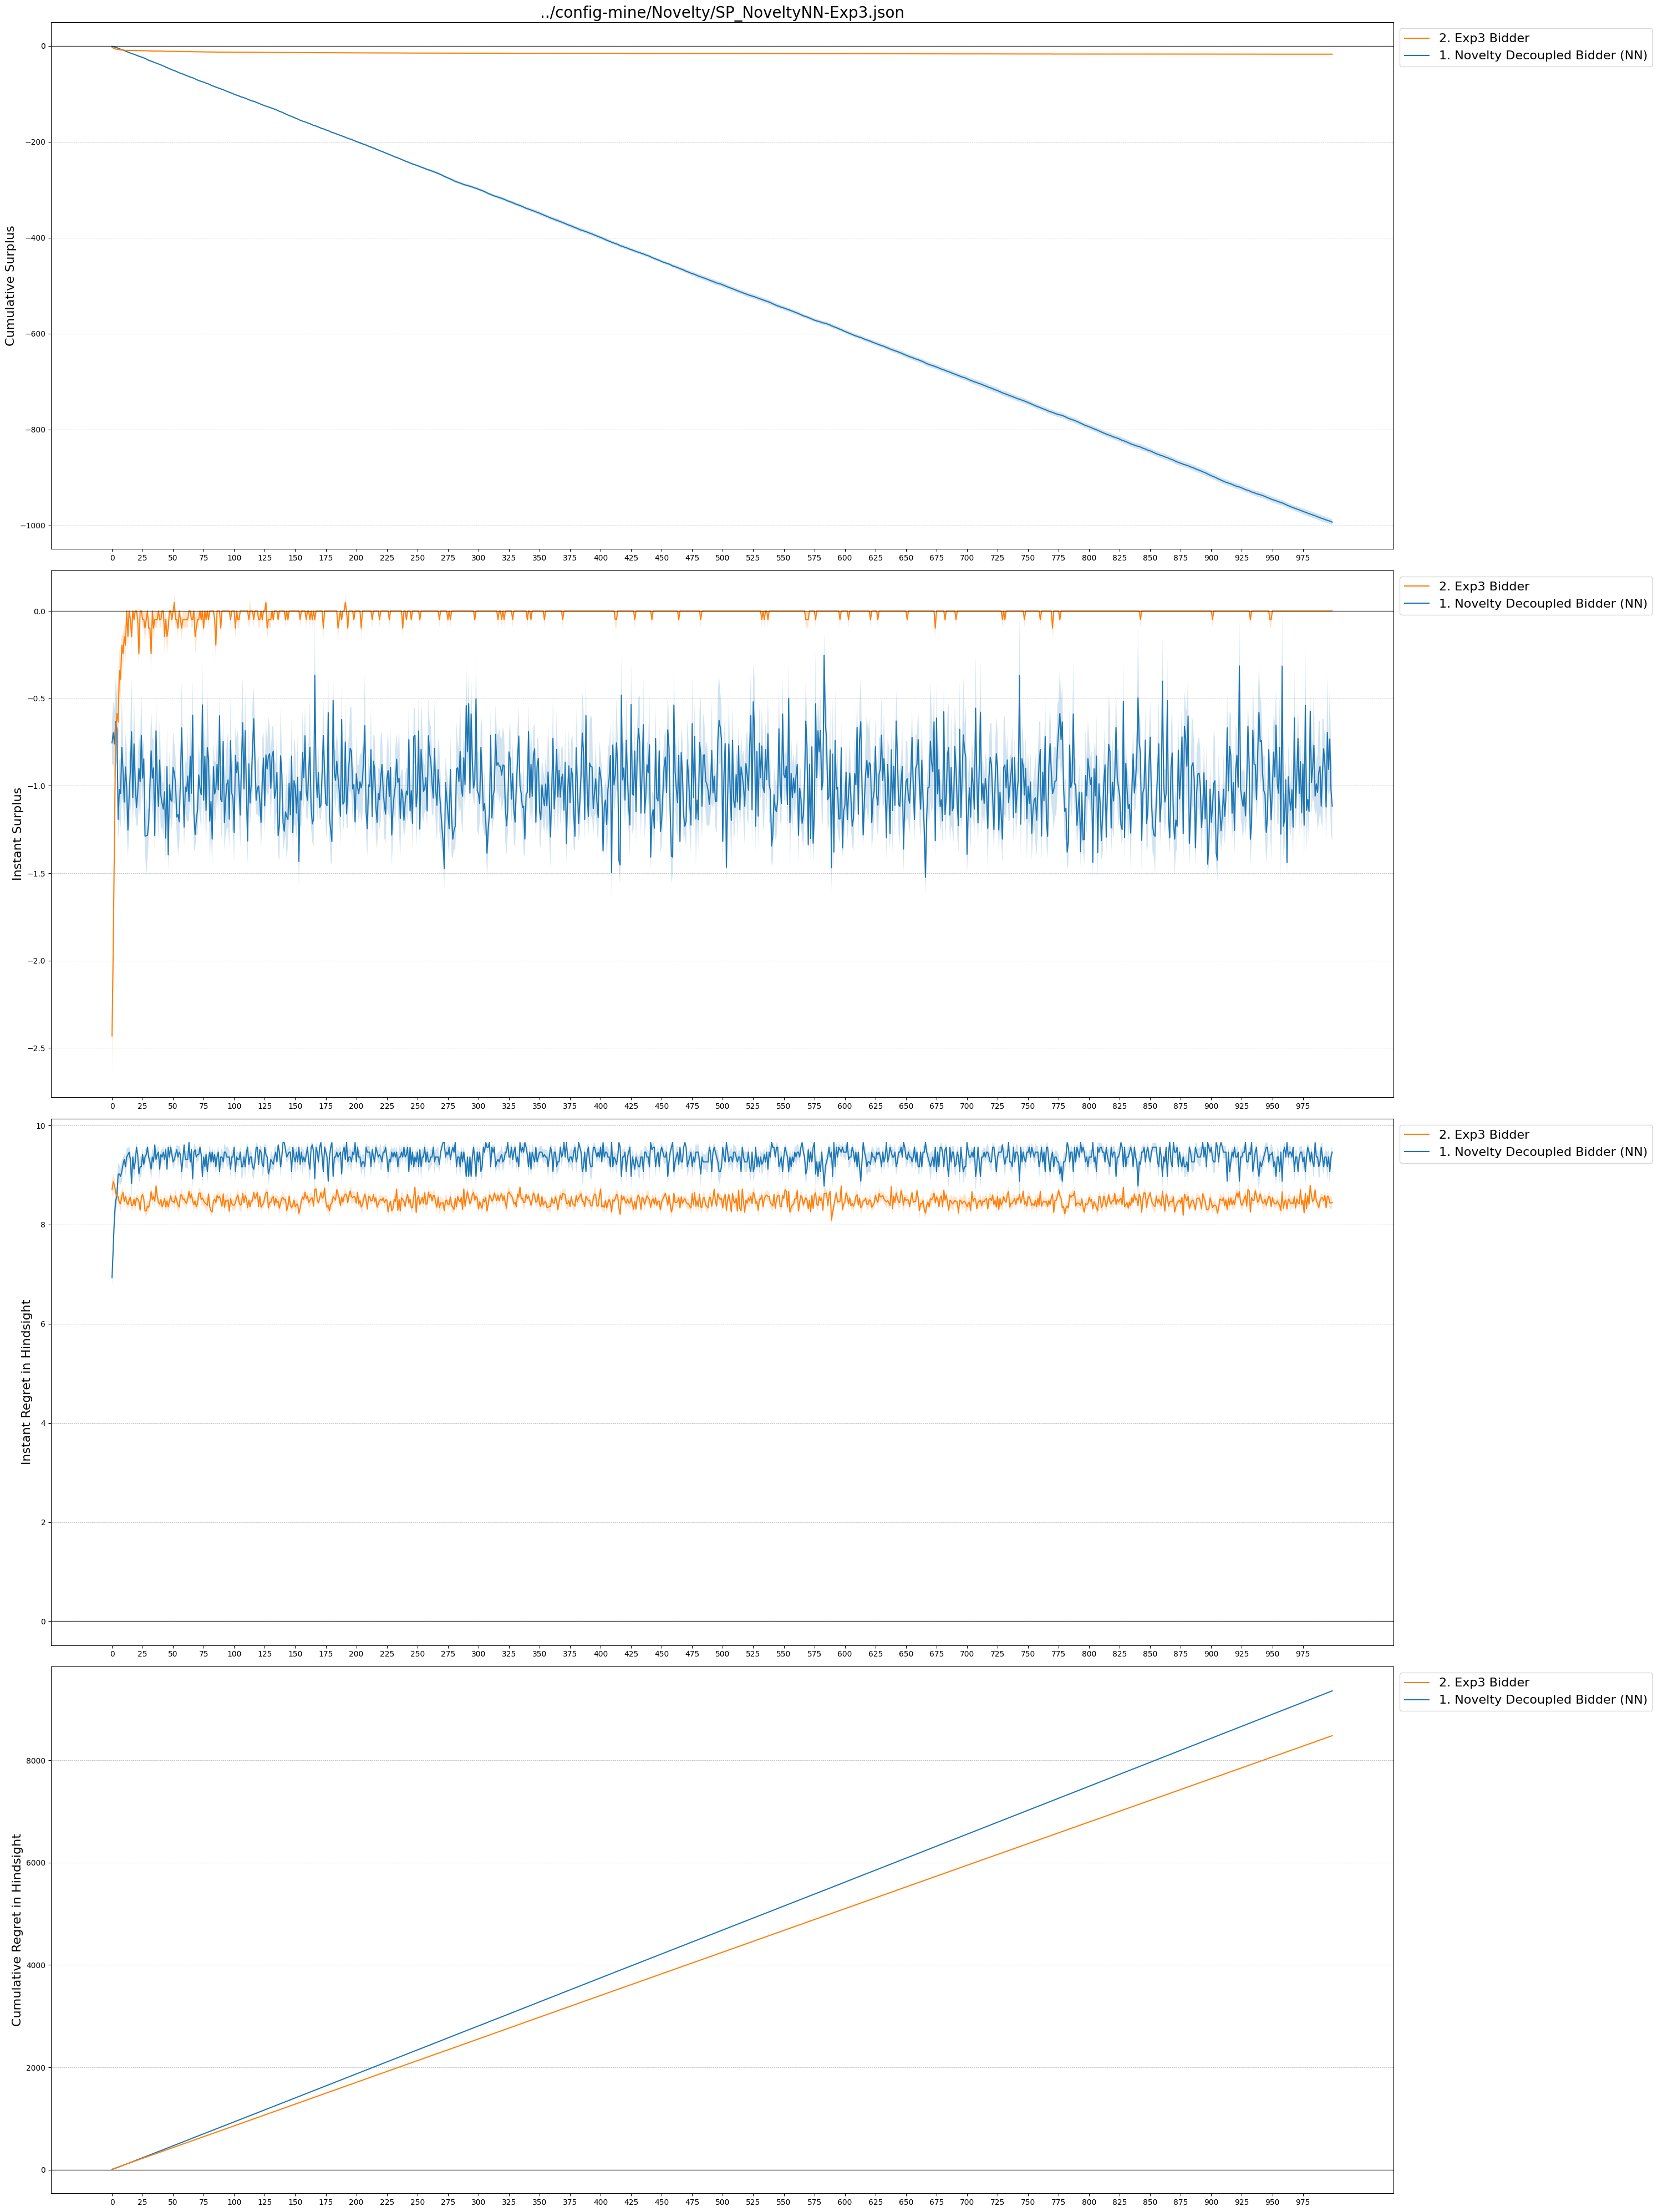

In [ ]:
%matplotlib inline

show_graph(runs_results)

In [ ]:
%matplotlib qt

show_graph(runs_results)